<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/2019_tf/airline2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airline Embeddings

_Basic assumption: airlines fliying similar routes are similar_

## Data Sets
* Single Flights: http://stat-computing.org/dataexpo/2009/the-data.html
* Routes between airports: https://openflights.org/data.html#route

## Advanced examples
* autoencoders on tabular data: https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/2019_tf/autoencoders_tabular.ipynb
* robust training on additional data: https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/2019_tf/autoencoders_stabilize.ipynb

In [1]:
!curl -O https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2321k  100 2321k    0     0  8060k      0 --:--:-- --:--:-- --:--:-- 8060k


In [0]:
# pd.read_csv?

In [3]:
import pandas as pd

df = pd.read_csv('routes.dat', quotechar="'", sep=',', encoding='utf-8', header=None, na_values='\\N',
                names=['Airline', 'Airline ID', 'Source airport', 'Source airport ID', 'Destination airport', 'Destination airport ID', 'Codeshare', 'Stops', 'Equipment'])

# https://openflights.org/data.html#route
  
# Airline	2-letter (IATA) or 3-letter (ICAO) code of the airline.
# Airline ID	Unique OpenFlights identifier for airline (see Airline).
# Source airport	3-letter (IATA) or 4-letter (ICAO) code of the source airport.
# Source airport ID	Unique OpenFlights identifier for source airport (see Airport)
# Destination airport	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
# Destination airport ID	Unique OpenFlights identifier for destination airport (see Airport)
# Codeshare	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
# Stops	Number of stops on this flight ("0" for direct)
# Equipment	3-letter codes for plane type(s) generally used on this flight, separated by spaces

# df[df['Stops'] == 1] gives only a dozen or so routes, so also drop it
df.drop(['Airline ID',	'Source airport ID', 'Destination airport ID', 'Codeshare', 'Equipment', 'Stops'], axis='columns', inplace=True)
len(df)

67663

In [4]:
df.head()

,Airline,Source airport,Destination airport
0,2B,AER,KZN
1,2B,ASF,KZN
2,2B,ASF,MRV
3,2B,CEK,KZN
4,2B,CEK,OVB


In [5]:
sources = df['Source airport'].unique()
len(sources)

3409

In [6]:
destinations = df['Destination airport'].unique()
len(destinations)

3418

In [7]:
airlines = df['Airline'].unique()
len(airlines)

568

In [8]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.13.1


In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

airline_tokenizer = Tokenizer()
airline_tokenizer.fit_on_texts(df['Airline'])

import numpy as np

encoded_airlines = np.array(airline_tokenizer.texts_to_sequences(df['Airline'])).reshape(-1)
encoded_airlines

array([241, 241, 241, ..., 543, 543, 543])

In [10]:
len(encoded_airlines) 

67663

In [11]:
routes = df[['Source airport', 'Destination airport']].apply(lambda x: ' '.join(x), axis=1)
routes.head()

0    AER KZN
1    ASF KZN
2    ASF MRV
3    CEK KZN
4    CEK OVB
dtype: object

In [0]:
routes_tokenizer = Tokenizer()
routes_tokenizer.fit_on_texts(routes)
encoded_routes = np.array(routes_tokenizer.texts_to_sequences(routes))

In [13]:
# should be a bit more 3400 as source and destination are from the same set
output_dim = len(routes_tokenizer.word_index) + 1
output_dim

3426

In [14]:
encoded_routes[0]

array([511, 491])

In [15]:
len(encoded_routes)

67663

In [0]:
from tensorflow.keras.utils import to_categorical

# sequence of airlines encoded as a unique number
x = encoded_airlines
# sequence of pair, src, dest encoded as a unique numbers
Y = to_categorical(encoded_routes)
# for now just the source
# Y = to_categorical(encoded_routes[:, 0])

In [17]:
Y[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## 2d embeddings

In [18]:
%%time

import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, GlobalAveragePooling1D, Dense, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, RepeatVector
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.initializers import glorot_normal
seed = 3

input_dim = len(airlines) + 1
embedding_dim = 2

model = Sequential()

model.add(Embedding(name='embedding',
                    input_dim=input_dim, 
                    output_dim=embedding_dim, 
                    input_length=1,
                    embeddings_initializer=glorot_normal(seed=seed)))

# https://stackoverflow.com/questions/49295311/what-is-the-difference-between-flatten-and-globalaveragepooling2d-in-keras
# averages over all (global) embedding values 
# model.add(GlobalAveragePooling1D())
model.add(Flatten())

model.add(Dense(units=50, activation='relu', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed)))

model.add(RepeatVector(2))

model.add(SimpleRNN(units=50, return_sequences=True, bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed)))

model.add(Dense(units=output_dim, name='output', activation='softmax', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed)))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 2)              1138      
_________________________________________________________________
flatten (Flatten)            (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 50)                150       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 2, 50)             0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 2, 50)             5050      
_________________________________________________________________
output (Dense)               (None, 2, 3426)           174726    
Total params: 181,064
Trainable params: 181,064
Non-trainable params: 0
_________________________________________________________________
CPU 

In [19]:
model.predict(np.array([x[0]]))

array([[[0.00029187, 0.00029189, 0.00029188, ..., 0.00029186,
         0.00029188, 0.00029189],
        [0.00029186, 0.00029187, 0.00029185, ..., 0.00029188,
         0.00029187, 0.00029189]]], dtype=float32)

In [20]:
Y[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
%%time

EPOCHS=25
BATCH_SIZE=10

history = model.fit(x, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/25
67663/67663 [==============================] - 43s 634us/sample - loss: 6.1470 - acc: 0.0392
Epoch 2/25
67663/67663 [==============================] - 45s 662us/sample - loss: 5.2131 - acc: 0.0895
Epoch 3/25
67663/67663 [==============================] - 42s 626us/sample - loss: 4.8773 - acc: 0.1150
Epoch 4/25
67663/67663 [==============================] - 43s 635us/sample - loss: 4.7051 - acc: 0.1286
Epoch 5/25
67663/67663 [==============================] - 42s 627us/sample - loss: 4.5976 - acc: 0.1376
Epoch 6/25
67663/67663 [==============================] - 41s 611us/sample - loss: 4.5243 - acc: 0.1438
Epoch 7/25
67663/67663 [==============================] - 43s 635us/sample - loss: 4.4705 - acc: 0.1467
Epoch 8/25
67663/67663 [==============================] - 42s 619us/sample - loss: 4.4298 - acc: 0.1484
Epoch 9/25
67663/67663 [==============================] - 43s 634us/sample - loss: 4.3994 - acc: 0.1496
Epoch 10/25
67663/67663 [==============================] - 43s 6

In [22]:
loss, accuracy = model.evaluate(x, Y, batch_size=BATCH_SIZE)
loss, accuracy

67663/67663 [==============================] - 24s 353us/sample - loss: 4.1585 - acc: 0.1613


(4.158455274742248, 0.16129199)

In [0]:
# plt.yscale('log')
plt.plot(history.history['loss'])

In [0]:
# plt.yscale('log')
plt.plot(history.history['acc'])

In [0]:
samples = pd.DataFrame(encoded_airlines).sample(n=200).values.reshape(-1)

In [0]:
# https://en.wikipedia.org/wiki/List_of_airline_codes
# https://en.wikipedia.org/wiki/List_of_largest_airlines_in_North_America
# https://en.wikipedia.org/wiki/List_of_largest_airlines_in_Europe

europe_airlines = ['LH', 'BA', 'SK', 'KL', 'AF', 'FR', 'SU', 'EW', 'TP', 'BT', 'U2']
us_airlines = ['AA', 'US', 'UA', 'WN', 'DL', 'AS', 'HA']

In [0]:
samples = [airline_tokenizer.word_index[airline_code.lower()] for airline_code in europe_airlines + us_airlines]

In [0]:
embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_2d = embedding_model.predict(samples).reshape(-1, 2)

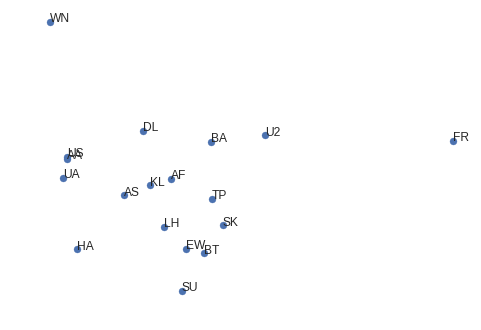

In [0]:
# for printing only
# plt.figure(dpi=600)
plt.axis('off')

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for index, x_pos, y_pos in zip(samples, embeddings_2d[:, 0], embeddings_2d[:, 1]):
  name = airline_tokenizer.index_word[index].upper()
#   print(name, (x_pos, y_pos))
  plt.annotate(name, (x_pos, y_pos))

## 1d embeddings

In [0]:
%%time

import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, GlobalAveragePooling1D, Dense, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, RepeatVector
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.initializers import glorot_normal
seed = 7

input_dim = len(airlines) + 1
embedding_dim = 1

model = Sequential()

model.add(Embedding(name='embedding',
                    input_dim=input_dim, 
                    output_dim=embedding_dim, 
                    input_length=1,
                   embeddings_initializer=glorot_normal(seed=seed)))

# model.add(GlobalAveragePooling1D())
model.add(Flatten())

model.add(Dense(units=50, activation='relu', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed)))

model.add(RepeatVector(2))

model.add(SimpleRNN(units=50, return_sequences=True, bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed)))

model.add(Dense(units=output_dim, name='output', activation='softmax', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed)))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 1)              569       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                100       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 2, 50)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 2, 50)             5050      
_________________________________________________________________
output (Dense)               (None, 2, 3426)           174726    
Total params: 180,445
Trainable params: 180,445
Non-trainable params: 0
_________________________________________________________________
CPU 

Epoch 1/20
67663/67663 [==============================] - 68s 1ms/sample - loss: 6.3561 - acc: 0.0231
Epoch 2/20
67663/67663 [==============================] - 67s 997us/sample - loss: 5.6996 - acc: 0.0449
Epoch 3/20
67663/67663 [==============================] - 68s 998us/sample - loss: 5.4424 - acc: 0.0599
Epoch 4/20
67663/67663 [==============================] - 68s 999us/sample - loss: 5.2960 - acc: 0.0662
Epoch 5/20
67663/67663 [==============================] - 67s 996us/sample - loss: 5.1944 - acc: 0.0712
Epoch 6/20
67663/67663 [==============================] - 67s 996us/sample - loss: 5.1216 - acc: 0.0748
Epoch 7/20
67663/67663 [==============================] - 67s 993us/sample - loss: 5.0701 - acc: 0.0774
Epoch 8/20
67663/67663 [==============================] - 67s 996us/sample - loss: 5.0274 - acc: 0.0794
Epoch 9/20
67663/67663 [==============================] - 67s 994us/sample - loss: 4.9936 - acc: 0.0806
Epoch 10/20
67663/67663 [==============================] - 67s 992

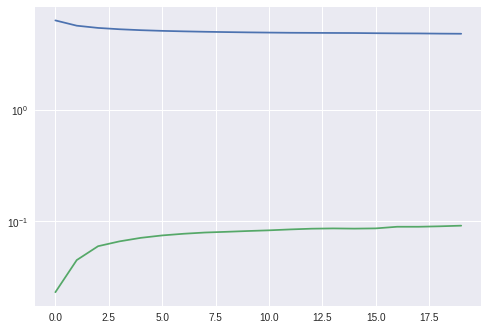

In [0]:
%%time

EPOCHS=20
BATCH_SIZE=10

history = model.fit(x, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

plt.yscale('log')
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])

In [0]:
# we expect this to be substantially worse than the 2d version as the bottle neck now is much more narrow
loss, accuracy = model.evaluate(x, Y, batch_size=BATCH_SIZE)
loss, accuracy

67663/67663 [==============================] - 38s 555us/sample - loss: 4.7625 - acc: 0.0909


(4.762505492797888, 0.090906404)

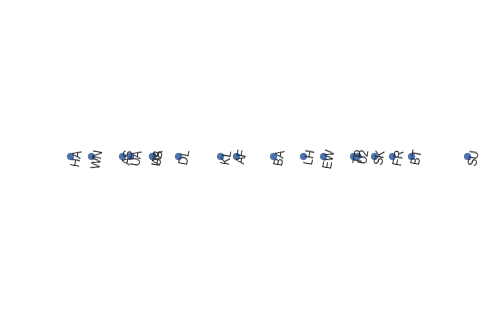

In [0]:
import numpy as np

embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_1d = embedding_model.predict(samples).reshape(-1)

# for printing only
# plt.figure(figsize=(20,5))
# plt.figure(dpi=600)
plt.axis('off')

plt.scatter(embeddings_1d, np.zeros(len(embeddings_1d)))
for index, x_pos in zip(samples, embeddings_1d):
  name = airline_tokenizer.index_word[index].upper()
#   print(name, (x_pos, y_pos))
  plt.annotate(name, (x_pos, 0), rotation=80)

## 2d embedding reduced via PCA 

much worse, as semantics are getting lost



In [0]:
from sklearn.decomposition import PCA

X = embeddings_2d

pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [0]:
pca.explained_variance_ratio_

array([0.5469235 , 0.45307645], dtype=float32)

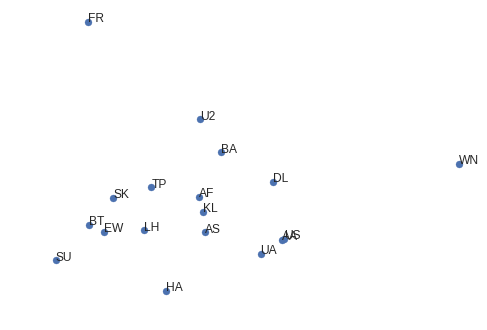

In [0]:
X_transformed = pca.transform(X)
# for printing only
# plt.figure(dpi=600)
plt.axis('off')

plt.scatter(X_transformed[:, 0], X_transformed[:, 1])
for index, x_pos, y_pos in zip(samples, X_transformed[:, 0], X_transformed[:, 1]):
  name = airline_tokenizer.index_word[index].upper()
#   print(name, (x_pos, y_pos))
  plt.annotate(name, (x_pos, y_pos))

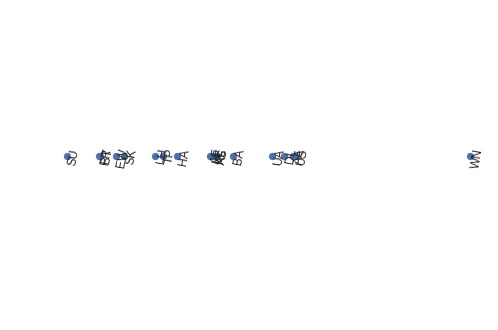

In [0]:
pca = PCA(n_components=1)
pca.fit(X)
X_transformed = pca.transform(X)
# for printing only
# plt.figure(figsize=(20,5))
# plt.figure(dpi=600)
plt.axis('off')

plt.scatter(X_transformed, np.zeros(len(X_transformed)))
for index, x_pos in zip(samples, X_transformed):
  name = airline_tokenizer.index_word[index].upper()
#   print(name, (x_pos, y_pos))
  plt.annotate(name, (x_pos, 0), rotation=80)

## Clustering in 2d

1d embedding vs size of airline
* find what is similar
* what is an outlier

In [0]:
# https://en.wikipedia.org/wiki/List_of_airline_codes
# https://en.wikipedia.org/wiki/List_of_largest_airlines_in_North_America
# https://www.tvlon.com/resources/airlinecodes.htm
# https://en.wikipedia.org/wiki/List_of_largest_airlines_in_Europe

airline_size = {
    'LH': 130, 'BA': 105, 'SK': 30, 'KL': 101, 'AF': 101, 'FR': 129, 'SU': 56, 'EW': 24, 'TP': 16, 'BT': 4, 'U2': 88, 'AA': 204, 'US': 204, 'UA': 158, 'WN': 164, 'DL': 192, 'AS': 46, 'HA': 12
}
sample_names = [airline_tokenizer.index_word[sample].upper() for sample in samples]
sample_sizes = [airline_size[name] * 1e6 for name in sample_names]

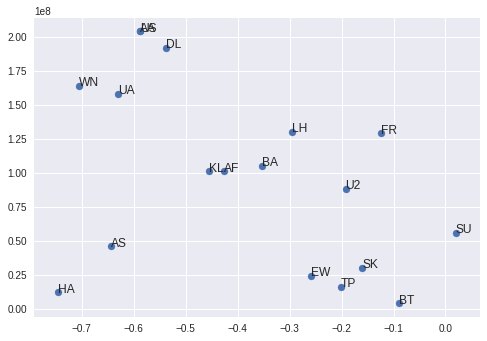

In [0]:
# for printing only
# plt.figure(figsize=(20,5))
# plt.figure(dpi=600)
# plt.axis('off')

plt.scatter(embeddings_1d, sample_sizes)
for name, x_pos, y_pos in zip(sample_names, embeddings_1d, sample_sizes):
  plt.annotate(name, (x_pos,  y_pos))

In [0]:
from sklearn.preprocessing import StandardScaler

embeddings_1d_scaled = StandardScaler().fit_transform(embeddings_1d.reshape(-1, 1))
sizes_for_samples_scaled = StandardScaler().fit_transform(np.array(sample_sizes).reshape(-1, 1))
X = np.dstack((embeddings_1d_scaled.reshape(-1), sizes_for_samples_scaled.reshape(-1)))[0]
X_scaled = StandardScaler().fit_transform(X)
X_scaled

array([[ 0.40075008,  0.48321195],
       [ 0.14787165,  0.10570261],
       [ 0.99537998, -1.0268254 ],
       [-0.29804232,  0.04530112],
       [-0.16714975,  0.04530112],
       [ 1.1516618 ,  0.46811158],
       [ 1.78620711, -0.63421569],
       [ 0.56405324, -1.11742764],
       [ 0.81762773, -1.23823063],
       [ 1.30737667, -1.41943512],
       [ 0.85509389, -0.15100374],
       [-0.87697501,  1.6006396 ],
       [-0.87733413,  1.6006396 ],
       [-1.06170595,  0.90602241],
       [-1.39185666,  0.99662466],
       [-0.65849842,  1.41943512],
       [-1.12466478, -0.78521943],
       [-1.56979512, -1.29863213]])

In [0]:
from sklearn.cluster import DBSCAN

clf = DBSCAN(eps=0.75, min_samples=2)
clf.fit(X_scaled)
clusters = clf.labels_.astype(np.int)
clusters

array([ 0,  0,  1,  0,  0,  2, -1,  1,  1,  1,  2,  3,  3,  3,  3,  3,  4,
        4])

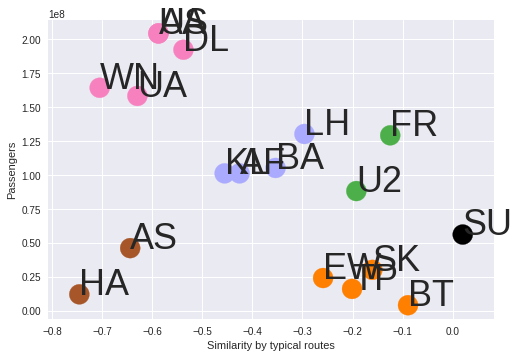

In [0]:
import matplotlib.pyplot as plt

from itertools import cycle, islice

# last color is black to properly display label -1 as noise (black)
colors = np.append(np.array(list(islice(cycle(['#AAAAFF', '#ff7f00', '#4daf4a',
                                 '#f781bf', '#a65628', '#984ea3',
                                 '#999999', '#e41a1c', '#dede00']),
                          int(max(clusters) + 1)))), ['#000000'])

# plt.figure(dpi=600)

plt.xlabel('Similarity by typical routes')
plt.ylabel('Passengers')

plt.scatter(embeddings_1d, sample_sizes, color=colors[clusters], s=400)
for name, x_pos, y_pos in zip(sample_names, embeddings_1d, sample_sizes):
  plt.annotate(name, (x_pos,  y_pos), fontsize=36)


In [0]:
X = StandardScaler().fit_transform(embeddings_2d)

clf = DBSCAN(eps=0.75, min_samples=2)
clf.fit(X)
clusters = clf.labels_.astype(np.int)
clusters

array([ 0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,
       -1])

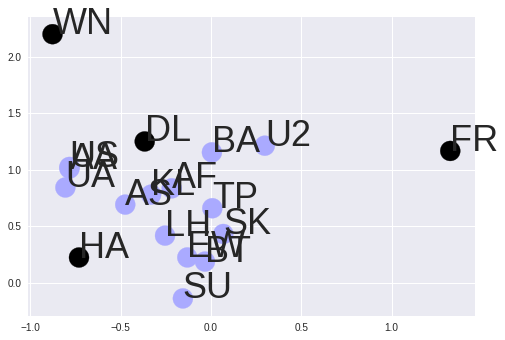

In [0]:
# for printing only
# plt.figure(dpi=600)
# plt.axis('off')

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color=colors[clusters], s=400)
# plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=400)
for index, x_pos, y_pos in zip(samples, embeddings_2d[:, 0], embeddings_2d[:, 1]):
  name = airline_tokenizer.index_word[index].upper()
#   print(name, (x_pos, y_pos))
  plt.annotate(name, (x_pos, y_pos), fontsize=36)